# SCICoNE
Here we will use the Python wrapper to facilitate plotting, and use the `verbose=True` flag to print out the corresponding command line calls to the compiled C++ program. Running this tutorial on a common laptop should take 5 to 10 minutes.

In [1]:
import scicone

install_path = '../build/'

temporary_outpath = './'
install_path = '/Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/build/'
temporary_outpath = '/Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/'
seed = 42 # for reproducibility

In [2]:
# Create SCICoNE object
sci = scicone.SCICoNE(install_path, temporary_outpath, verbose=True)

Using binaries at /Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/build/


Let's `simulate_data` with 200 cells, 1000 genomic bins and 10000 reads per cell, corresponding to an average coverage of 10 reads per bin, which is similar to the current 10x Genomics CNV platform. We set `nu=10.0` for moderate data overdispersion.

In [3]:
sim = sci.simulate_data(n_cells=200, n_nodes=5, n_bins=1000, n_regions=40,
                        n_reads=2000, nu=5.0, ploidy=2, seed=seed)

/Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/build/simulation --n_cells=200 --n_nodes=5 --n_regions=40 --n_bins=1000 --n_reads=2000 --nu=5.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=42
Simulating with maximum affected regions per node: 1
Assuming root to have copy number state 2 in all regions
Simulating with overdispersion, coefficient: 5
Sampling region sizes
Done sampling region sizes
Sampling counts
Done sampling counts
Successfully simulated.


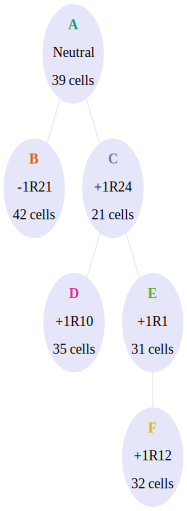

In [4]:
sim['tree'].plot_tree()

The output dictionary contains the counts matrix `d_mat`, the true CNVs `ground_truth`, the region sizes `region_sizes` and the underlying true `tree`.

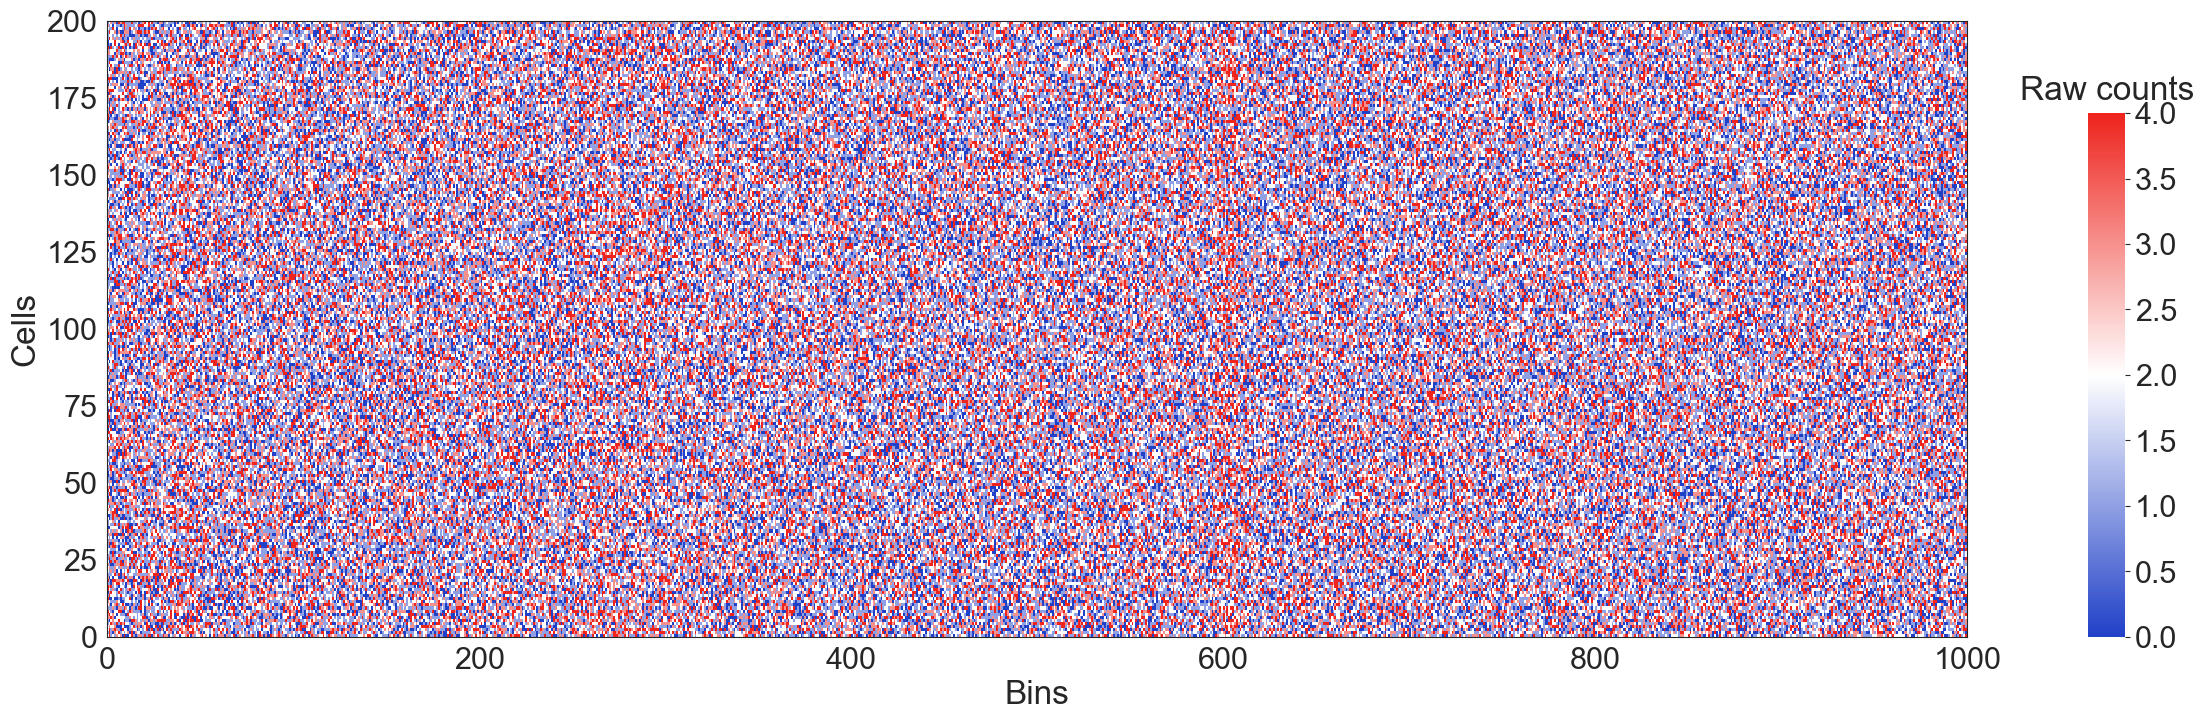

In [5]:
scicone.plotting.plot_matrix(sim['d_mat'], cbar_title='Raw counts', vmax=4)

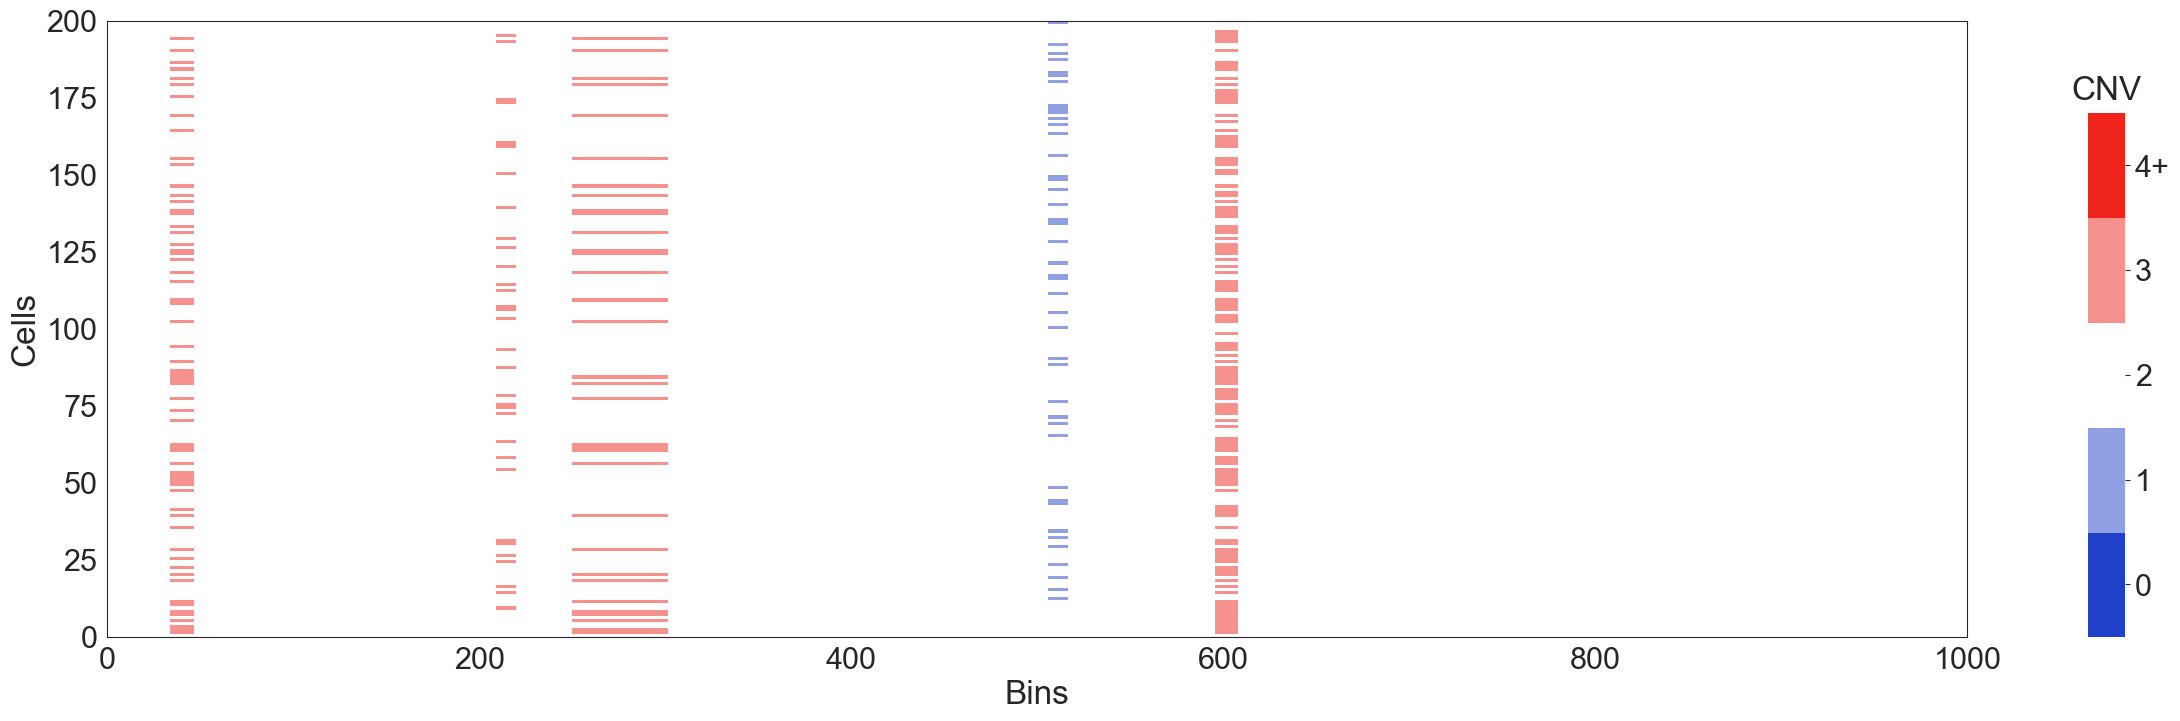

In [6]:
scicone.plotting.plot_matrix(sim['ground_truth'], mode='cnv', cbar_title='CNV')

The first step is to find the breakpoints that define copy number regions using the `breakpoint_detection` binary. The `threshold` parameter controls the sensitivity of the algorithm: lower thresholds lead to more bins being called as breakpoints and vice-versa. In general, detecting more breakpoints than needed is not a problem, since they can be eliminated during the tree inference.

In [7]:
bps = sci.detect_breakpoints(sim['d_mat'], threshold=3.0)

/Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=200 --window_size=30 --threshold=3.0 --bp_limit=300 --bp_min=0 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
min_cells is not specified, 4 cells are going to be considered
Reading the input matrix: PYSCICONETEMPbp_bp_detection.txt
Input matrix is read.
Computing the probability of a region being a breakpoint...
Method of moments estimated nu=0.623802
n_regions: 1
Combining scores...
Done.
Computed probabilities for all regions.
Replacing zeroes by the previous value, lest them to be effective in the breakpoint detection.
Zeroes are replaced by the previous value.
Try number 1
Index of the maximum 220 is added to all_max_ids.
Index of the maximum 578 is added to all_max_ids.
Index of the maximum 4 is added to al

The bin indices corresponding the detected breakpoints are stored in `bps['segmented_regions']`. We can check their accuracy by plotting them over the data matrix:

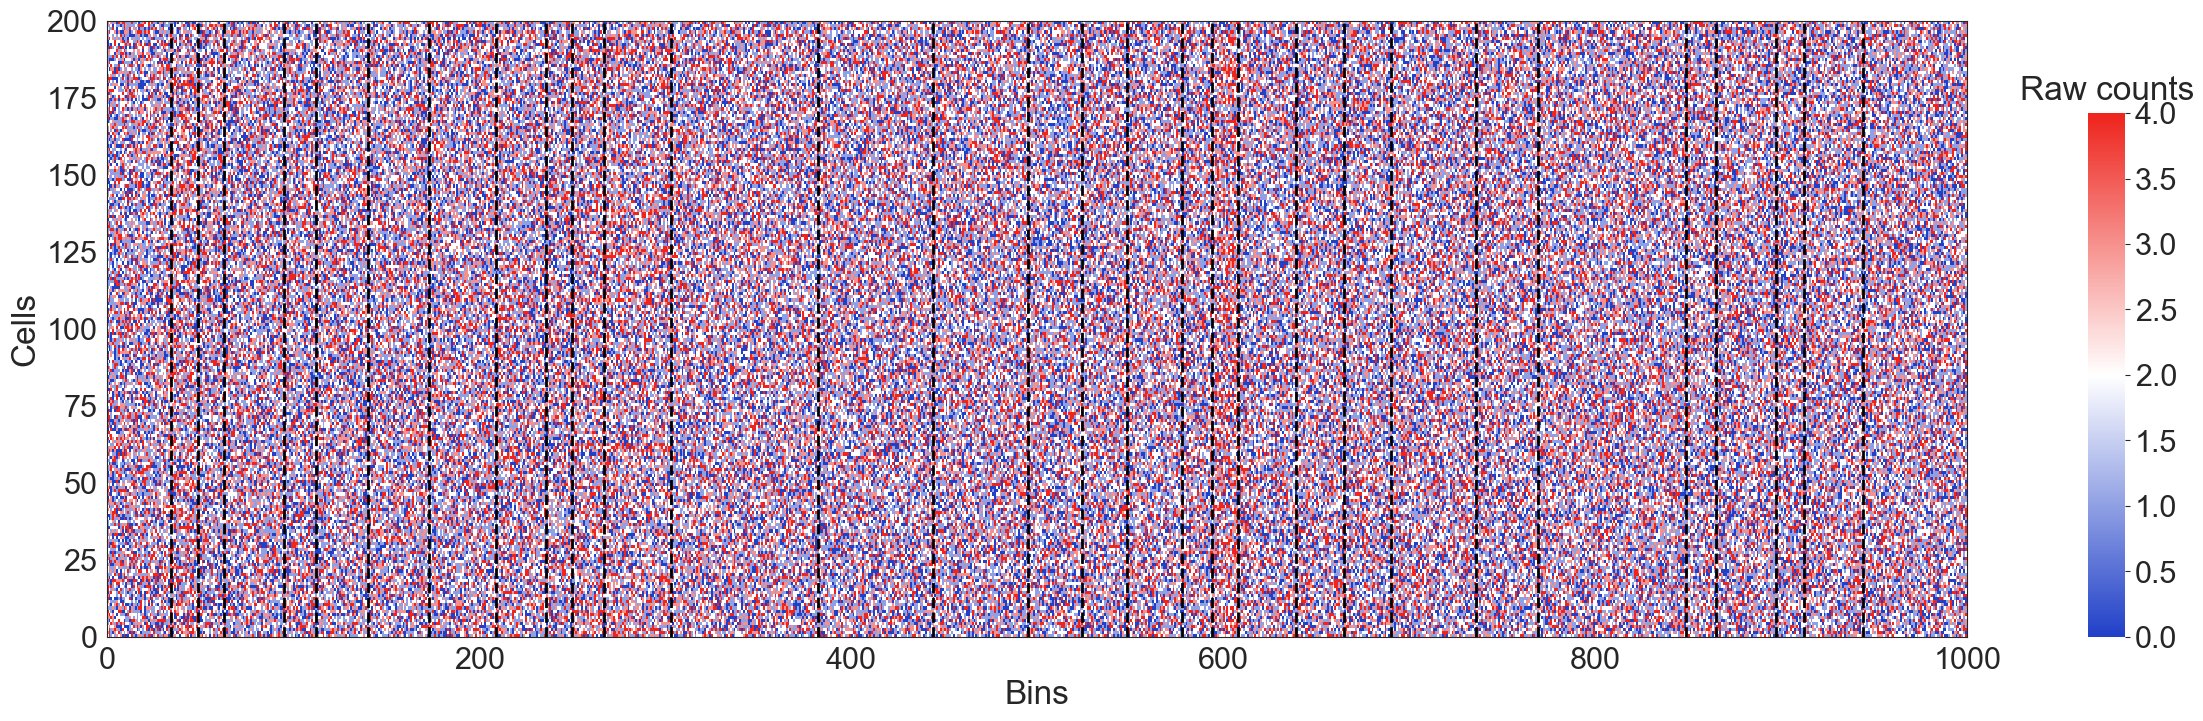

In [8]:
scicone.plotting.plot_matrix(sim['d_mat'], bps=bps['segmented_regions'], cbar_title='Raw counts', vmax=4)

We have recovered the true breakpoints, so now we can run `inference` to simultaneously find the CNV of each cell and the underlying mutation tree. By default, this will first find a tree on the clustered data, and then use that tree as a starting point for the tree search in the full data. Additionally, it uses Python's `multiprocessing` module to run multiple searches in parallel, stores the final trees in the `SCICoNE` object and outputs the highest scoring tree.

In [9]:
inferred_tree = sci.learn_tree(sim['d_mat'], bps['segmented_region_sizes'], n_reps=4, seed=seed)

Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 20
Setting min_cluster_size to 1
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.009658098220825195 seconds
Jaccard graph constructed in 0.0324549674987793 seconds
Wrote graph to binary file in 0.002135038375854492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.421571
After 16 runs, maximum modularity is Q = 0.424862
Louvain completed 36 runs in 1.3547661304473877 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 2.417179822921753 seconds
Found 6 clusters.
Cluster sizes: [40. 35. 34. 32. 30. 29.]
Creating /Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/rep0_try0_PYSCICONETREETEMP_PYSCICONETEMP...
Created /Users/dfridljand/Documents/Research_too_large/2024-Beerenwinkel/Python/SCICoNE/rep0_try0_PYSCICONETREETEMP_PYSCICONETEMP!
Trying to move to /Users/dfridljand/

The parameters for the best tree (like the inferred CNVs and other information related to its MCMC run) are available at `inferred_tree.outputs`. We use the `labels` keyword argument of the `plot_matrix` function to group cells belonging to the same clone together.

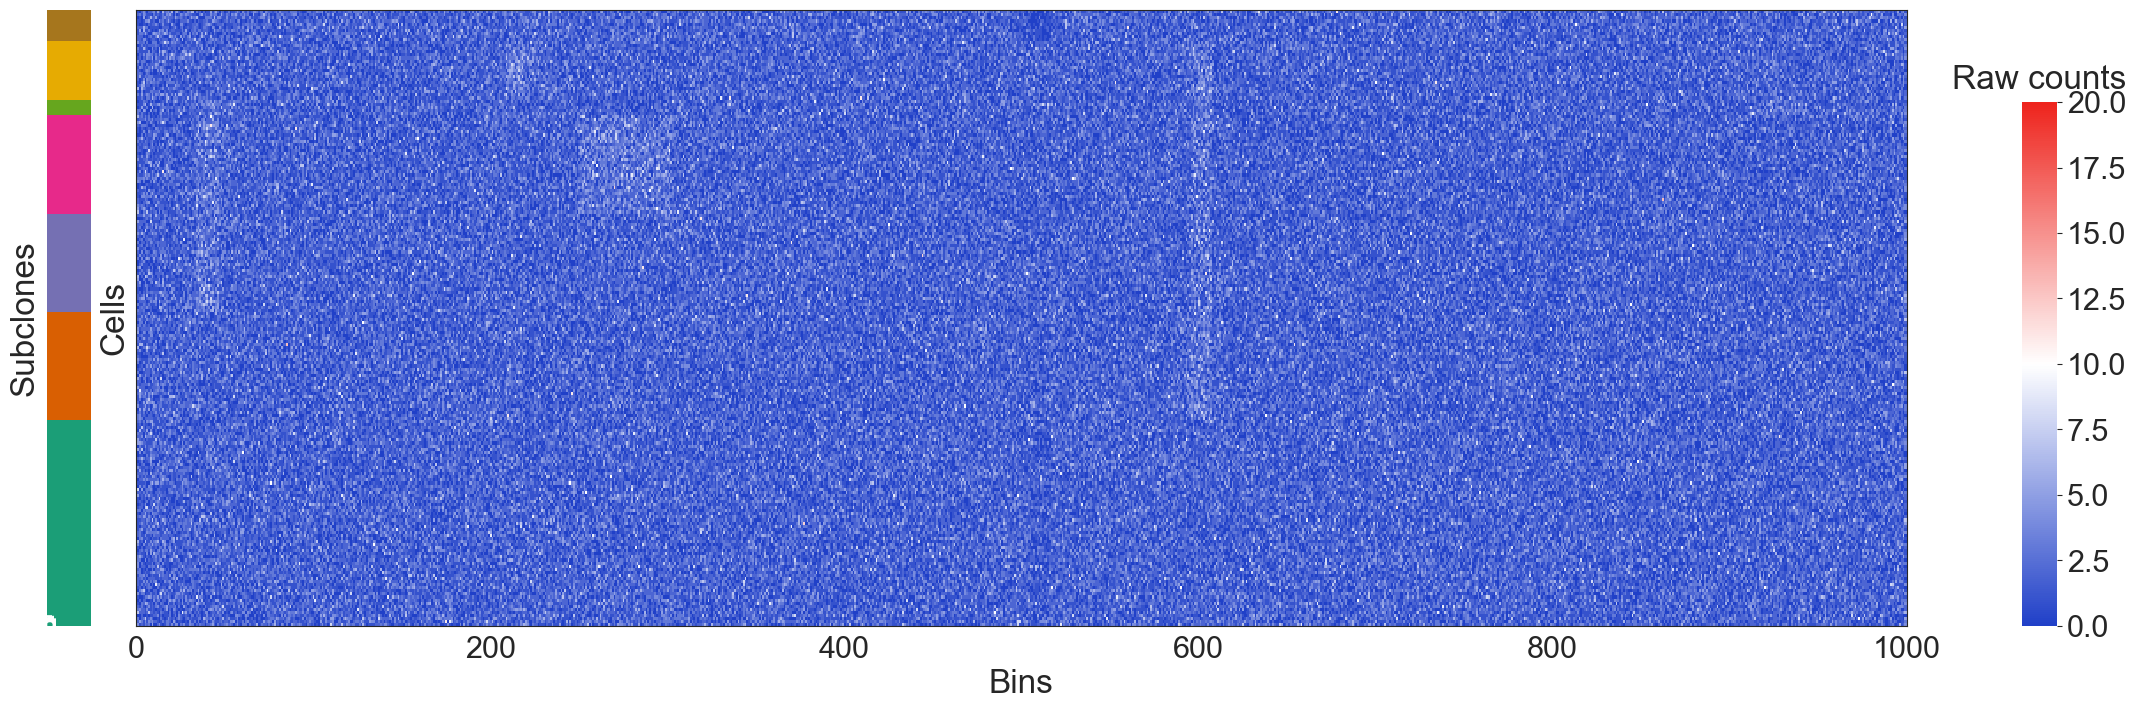

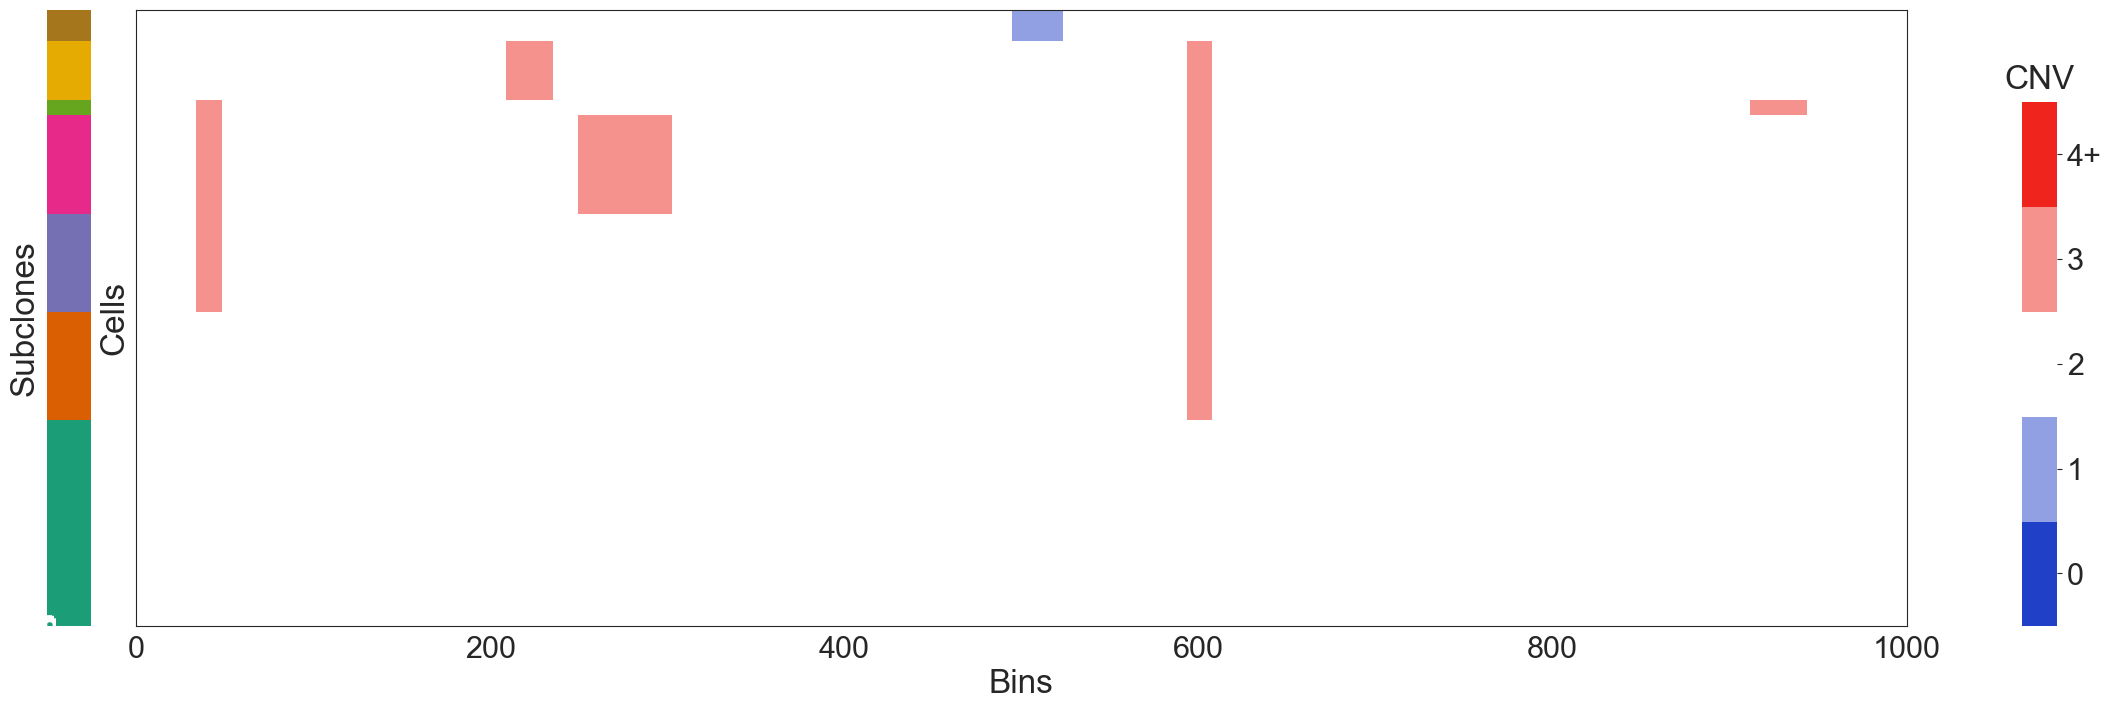

In [10]:
scicone.plotting.plot_matrix(sim['d_mat'], mode='data', cbar_title='Raw counts', vmax=20,
                            labels=inferred_tree.cell_node_labels)

scicone.plotting.plot_matrix(inferred_tree.outputs['inferred_cnvs'], mode='cnv', cbar_title='CNV',
                            labels=inferred_tree.cell_node_labels)

And the inferred tree can be plotted using `plot_tree()`, where each node is labeled by the copy number changes ocurring in the cells attached to it:

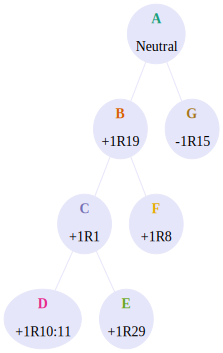

In [11]:
inferred_tree.plot_tree(node_labels=True, node_sizes=False)

For more information on how to use SCICoNE, including examples for running on data from the 10x Genomics CNV pipeline and integration with `snakemake`, please visit https://github.com/cbg-ethz/SCICoNE/.

In [12]:
# Let's remove diploid cells
import numpy as np
clone_a_cells_idx = np.where(np.array(inferred_tree.cell_node_labels) == 'A')[0]
clone_a_cells_counts = sim['d_mat'][clone_a_cells_idx]

In [13]:
tumor_cells_data = np.copy(sim['d_mat'])
tumor_cells_cn = np.copy(inferred_tree.outputs['inferred_cnvs'])
is_a = np.zeros((sim['d_mat'].shape[0],))
is_a[clone_a_cells_idx] = 1.
tumor_cells_data = tumor_cells_data[~is_a.astype(bool),:]
tumor_cells_cn = tumor_cells_cn[~is_a.astype(bool),:]

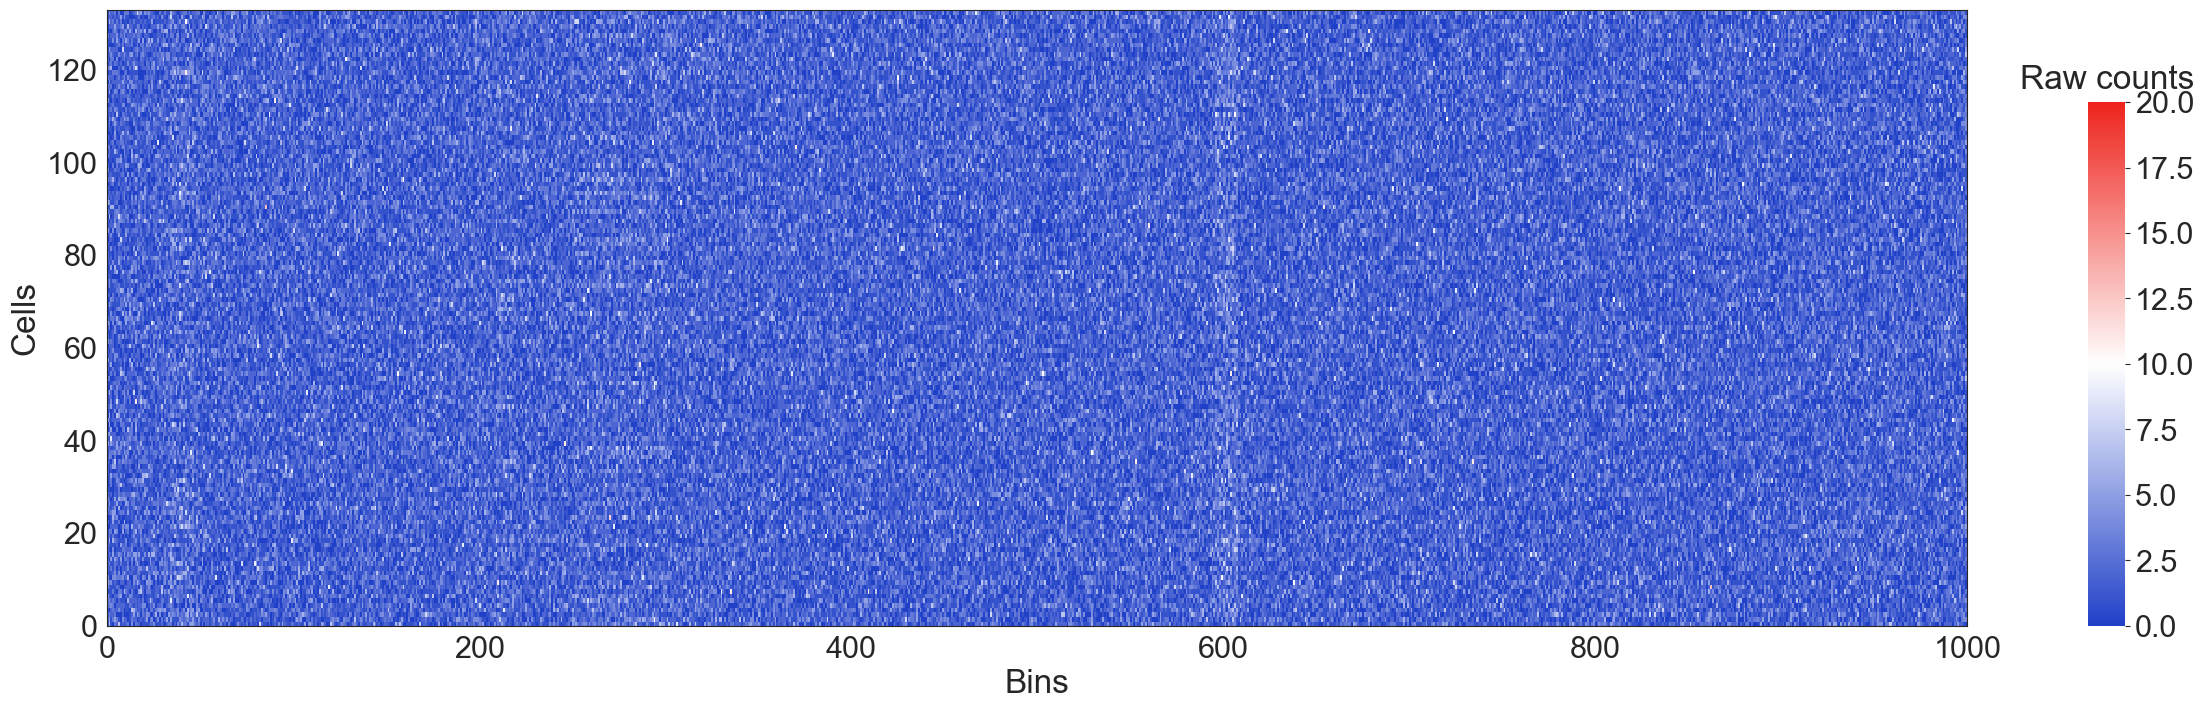

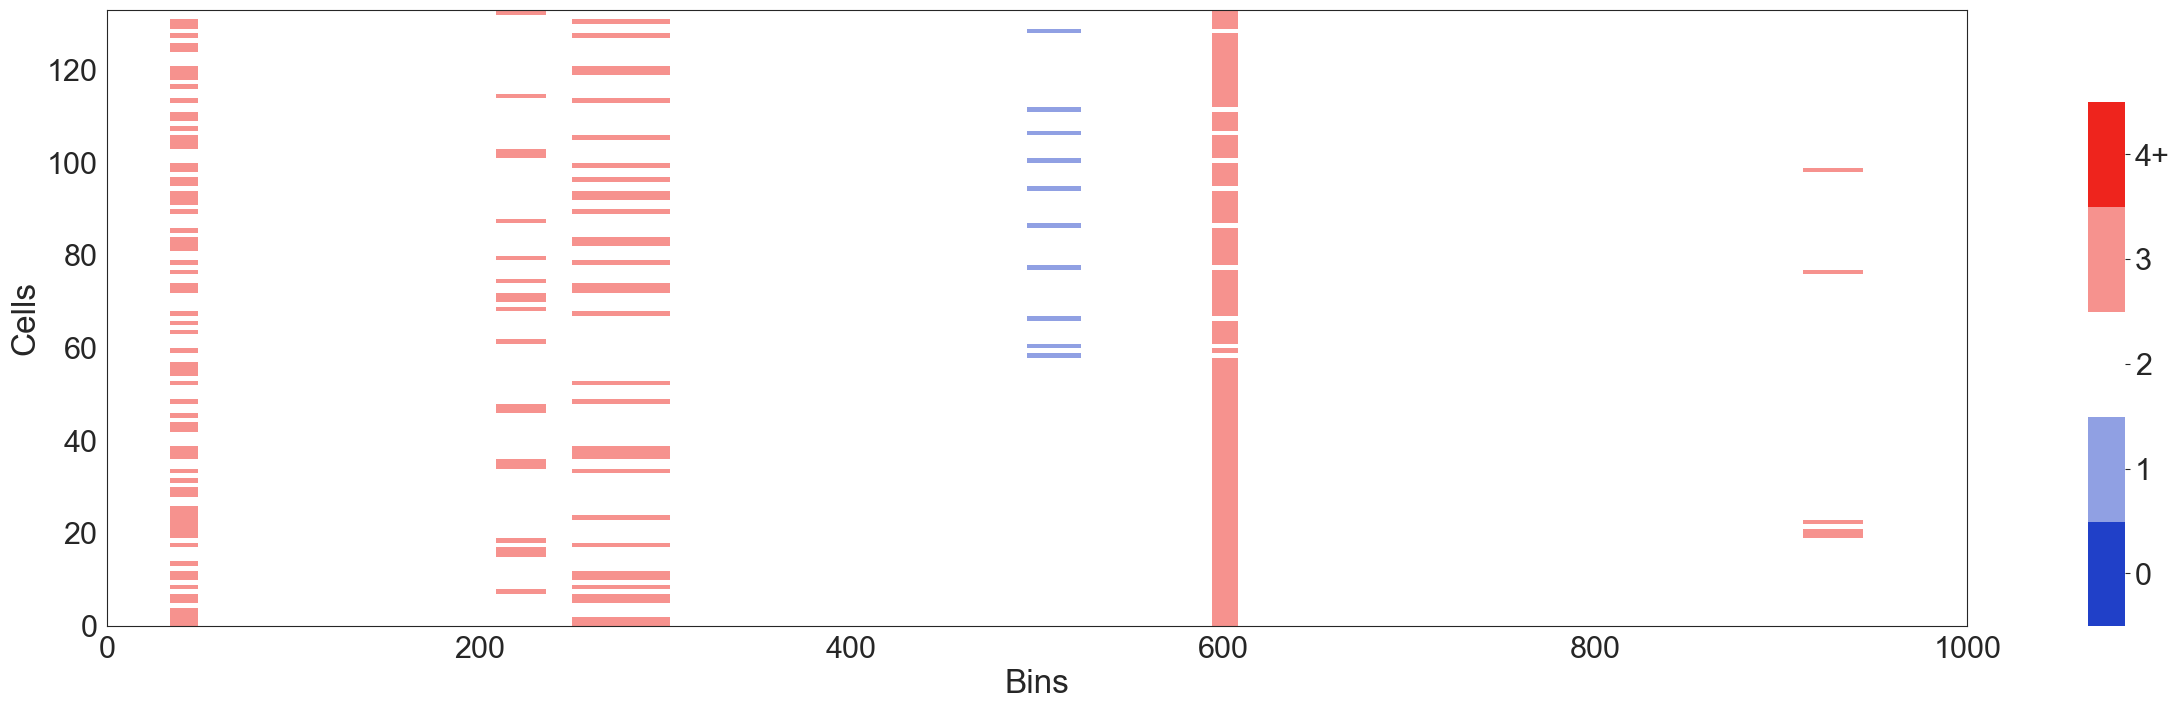

In [14]:
scicone.plotting.plot_matrix(tumor_cells_data, cbar_title='Raw counts', vmax=20)
scicone.plotting.plot_matrix(tumor_cells_cn, mode='cnv')

In [15]:
# Subsample the tumor cells for a desired fraction
N = 400
tumor_fraction = 0.1
T = int(N*tumor_fraction)
D = N - T
subsampled_tumor_cells = tumor_cells_data[np.random.randint(tumor_cells_data.shape[0], size=T),:]

In [16]:
tumor_fraction = 0.1
T = int(N*tumor_fraction)
D = N - T
selected_tumor_cells = np.random.randint(tumor_cells.shape[0], size=T)
subsampled_tumor_cells = tumor_cells[selected_tumor_cells,:]
subsampled_tumor_cells_cn = tumor_cells_cn[selected_tumor_cells,:]

augmented_data = np.concatenate([subsampled_tumor_cells, clone_a_cells_counts[
                    np.random.randint(clone_a_cells_counts.shape[0], size=D),:]], axis=0)

# True copy numbers
true_cn = np.ones((D,clone_a_cells_counts.shape[1])) * 2
true_cn = np.concatenate([subsampled_tumor_cells_cn, true_cn], axis=0)

NameError: name 'tumor_cells' is not defined

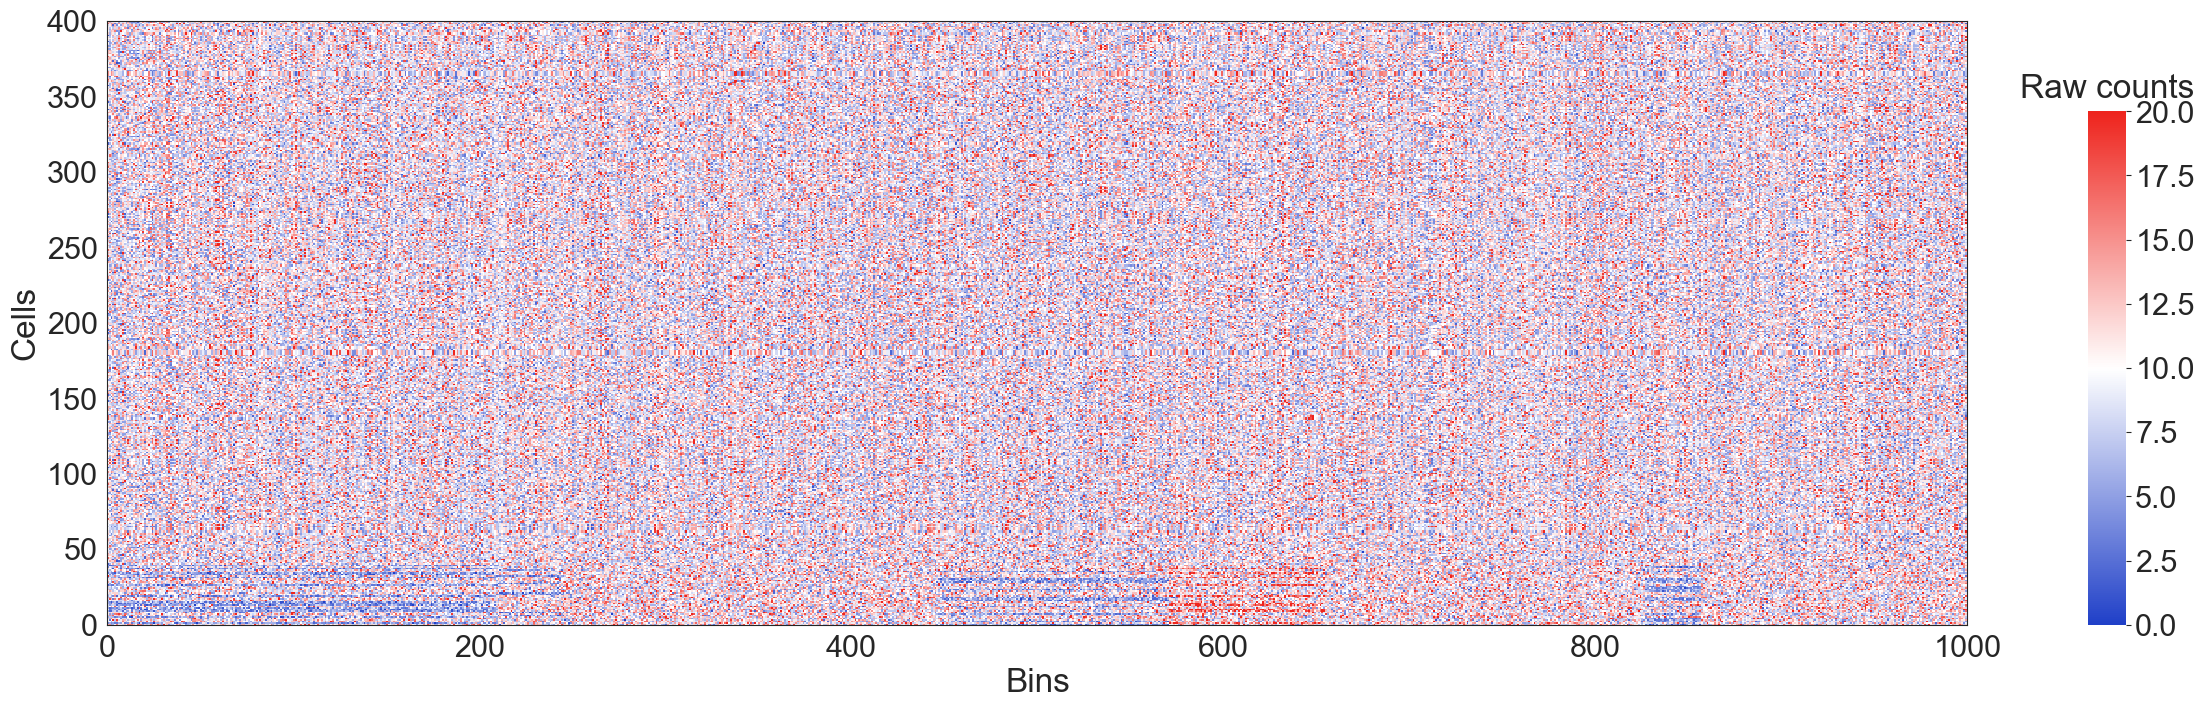

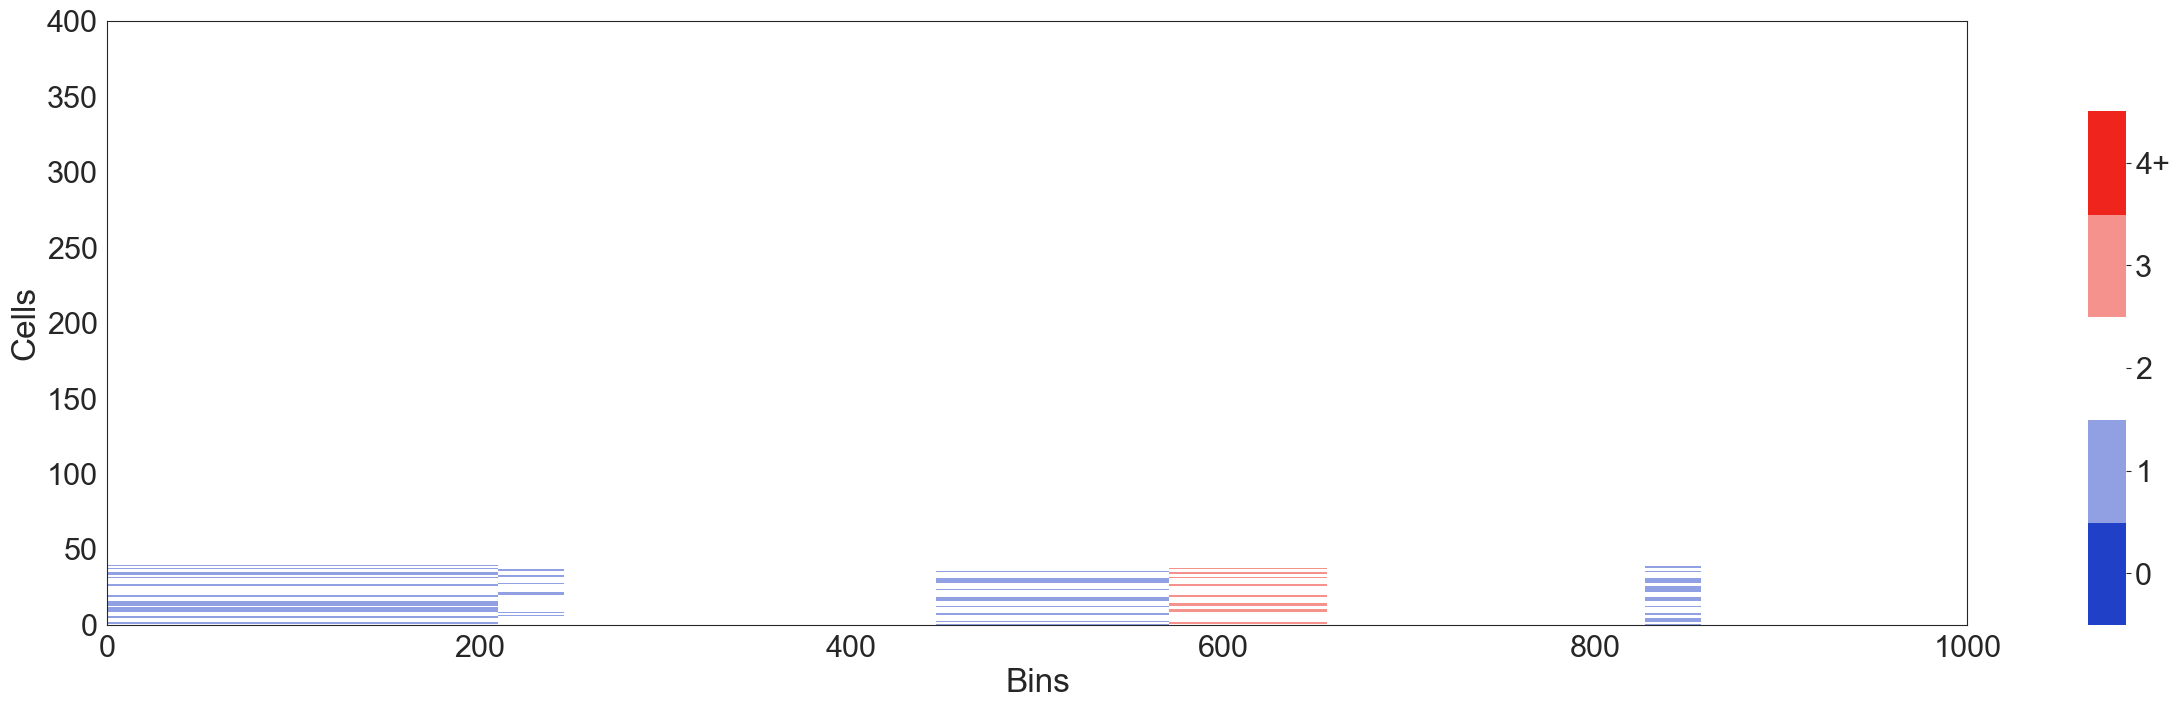

In [ ]:
scicone.plotting.plot_matrix(augmented_data, cbar_title='Raw counts', vmax=20)
scicone.plotting.plot_matrix(true_cn, mode='cnv')

In [ ]:
n_cells = [20, 40, 100, 200, 400]
tumor_fractions = [0.01, 0.05, 0.1, 0.2, 0.5, 0.7]
reps = [0, 1, 2]
deltas = []
baseline_deltas = []
n_clusters = []
true_n_clusters = []
cnvs_rows = []
clusters_rows = []
np.random.seed(42)
for N in n_cells:
    for tumor_fraction in tumor_fractions:
        for rep in reps:
            seed = np.random.randint(10000)
            
            # Simulate data
            sim = sci.simulate_data(n_cells=N, n_nodes=5, n_bins=1000, n_regions=10,
                                n_reads=10000, nu=10.0, ploidy=2, seed=seed)

            # Transform data to desired proportions
            clone_a_cells_idx = np.where(np.all(sim['tree'].outputs['inferred_cnvs']==np.ones((1000,))*2, axis=1))[0]
            clone_a_cells_counts = sim['d_mat'][clone_a_cells_idx]
            tumor_cells_data = np.copy(sim['d_mat'])
            tumor_cells_cn = np.copy(sim['tree'].outputs['inferred_cnvs'])
            is_a = np.zeros((sim['d_mat'].shape[0],))
            is_a[clone_a_cells_idx] = 1.
            tumor_cells_data = tumor_cells_data[~is_a.astype(bool),:]
            tumor_cells_cn = tumor_cells_cn[~is_a.astype(bool),:]
            T = int(N*tumor_fraction)
            D = N - T
            selected_tumor_cells = np.random.randint(tumor_cells_data.shape[0], size=T)
            subsampled_tumor_cells = tumor_cells_data[selected_tumor_cells,:]
            subsampled_tumor_cells_cn = tumor_cells_cn[selected_tumor_cells,:]
            augmented_data = np.concatenate([subsampled_tumor_cells, clone_a_cells_counts[
                                np.random.randint(clone_a_cells_counts.shape[0], size=D),:]], axis=0)

            # True copy numbers
            true_cn = np.ones((D,clone_a_cells_counts.shape[1])) * 2
            true_cn = np.concatenate([subsampled_tumor_cells_cn, true_cn], axis=0)

            # Call breakpoints
            bps = sci.detect_breakpoints(augmented_data, threshold=3.0, window_size=int(0.01*augmented_data.shape[1]))
            # Call copy number clones
            inferred_tree = sci.learn_tree(augmented_data, bps['segmented_region_sizes'], n_reps=4, full=False, 
                                           seed=seed)

            # Compare true vs called CNVs
            deltas.append(np.sqrt(np.mean((inferred_tree.outputs['inferred_cnvs'] - true_cn)**2)))
            baseline_deltas.append(np.sqrt(np.mean((np.ones(true_cn.shape)*2 - true_cn)**2)))
            n_clusters.append(len(np.unique(inferred_tree.outputs['inferred_cnvs'], axis=0)))
            true_n_clusters.append(len(np.unique(true_cn, axis=0)))
            
            cnvs_rows.append(dict(cnv_delta=deltas[-1], method='SCICoNE',
                            rep=rep, tumor_fraction=tumor_fraction, n_cells=N))
            cnvs_rows.append(dict(cnv_delta=baseline_deltas[-1], method='Diploid',
                            rep=rep, tumor_fraction=tumor_fraction, n_cells=N))
            
            clusters_rows.append(dict(clusters_delta=n_clusters[-1]-true_n_clusters[-1], method='SCICoNE',
                            rep=rep, tumor_fraction=tumor_fraction, n_cells=N))

../build/simulation --n_cells=20 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=7270
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=20 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 2
Setting min_cluster_size to 1
Finding 2 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0018229484558105469 seconds
Jaccard graph constructed in 0.0012400150299072266 seconds
Wrote graph to binary file in 0.0006299018859863281 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.475309
Louvain completed 21 run

Wrote graph to binary file in 0.001026153564453125 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.650519
Louvain completed 21 runs in 0.17052102088928223 seconds
PhenoGraph complete in 0.1800520420074463 seconds
Found 3 clusters.
Cluster sizes: [8. 7. 5.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=46 --n_cells=3 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2047 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=35 --n_cells=3 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3843 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=35 --n_cells=3 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3843 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCI

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=33 --n_cells=4 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3099 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=20 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=8110
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=20 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 2
Setting min_cluster_size to 1
Finding 2 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0026979446411132812 seconds
Jaccard graph constructed in 0.0010101795196533203 seconds
Wrote graph to binary file in 0.0021669864654541016 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.681562
Louvain completed 21 runs in 0.1960618495941162 seconds
PhenoGraph complete in 0.20658516883850098 seconds
Found 5 clusters.
Cluster sizes: [6. 4. 4. 3. 3.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt 

PhenoGraph complete in 0.2046949863433838 seconds
Found 5 clusters.
Cluster sizes: [1. 6. 6. 5. 2.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=53 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=5249 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=53 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1

../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=41 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=8680 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=41 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=8680 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCI

Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=20 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=1218
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=20 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 2
Setting min_cluster_size to 1
Finding 2 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.0036242008209228516 seconds
Jaccard graph constructed in 0.0020759105682373047 seconds
Wrote graph to binary file in 0.0005192756652832031 seconds
Running Louvain modularity optimization
After 

Neighbors computed in 0.005732059478759766 seconds
Jaccard graph constructed in 0.00395512580871582 seconds
Wrote graph to binary file in 0.0026340484619140625 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.746914
Louvain completed 21 runs in 0.21213483810424805 seconds
PhenoGraph complete in 0.2321779727935791 seconds
Found 4 clusters.
Cluster sizes: [11. 11.  9.  9.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=50 --n_cells=4 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=301 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lamb

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=54 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2491 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=54 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2491 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCI

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=62 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=5536 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=40 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=2143
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=40 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 4
Setting min_cluster_size to 1
Finding 4 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.004367828369140625 seconds
Jaccard graph constructed in 0.004772186279296875 seconds
Wrote graph to binary file in 0.0009551048278808594 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.777456
Louvain completed 21 runs in 0.27593016624450684 seconds
PhenoGraph complete in 0.2936708927154541 seconds
Found 5 clusters.
Cluster sizes: [11.  9.  9.  7.  4.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.t

PhenoGraph complete in 0.5447208881378174 seconds
Found 5 clusters.
Cluster sizes: [13.  9.  7.  6.  5.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=30 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3324 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=30 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,

../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=47 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=6881 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=47 --n_cells=5 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=6881 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCI

Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=40 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=6229
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=40 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 4
Setting min_cluster_size to 1
Finding 4 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.004962921142578125 seconds
Jaccard graph constructed in 0.0041539669036865234 seconds
Wrote graph to binary file in 0.0008690357208251953 seconds
Running Louvain modularity optimization
After 1

Neighbors computed in 0.004060983657836914 seconds
Jaccard graph constructed in 0.0021209716796875 seconds
Wrote graph to binary file in 0.0011208057403564453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.833383
Louvain completed 21 runs in 0.2884490489959717 seconds
PhenoGraph complete in 0.30274415016174316 seconds
Found 7 clusters.
Cluster sizes: [7. 7. 6. 6. 5. 5. 4.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=42 --n_cells=7 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2048 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 -

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=43 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=950 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=43 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=950 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCICO

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=72 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=4223 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=100 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=1762
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detectio

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=100 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 10
Setting min_cluster_size to 1
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.006440877914428711 seconds
Jaccard graph constructed in 0.015357017517089844 seconds
Wrote graph to binary file in 0.0037801265716552734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804818
After 3 runs, maximum modularity is Q = 0.812099
Louvain completed 23 runs in 0.38625001907348633 seconds
PhenoGraph complete in 0.42766594886779785 seconds
Found 7 clusters.
Cluster sizes: [23. 15. 15. 14. 13. 11.  9.]
../build/inference --d_matrix_file=re

Louvain completed 21 runs in 0.26054811477661133 seconds
PhenoGraph complete in 0.28443288803100586 seconds
Found 9 clusters.
Cluster sizes: [17. 15. 13. 11. 11.  9.  9.  8.  7.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=46 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=4167 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=46 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONET

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=70 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=575 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=70 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=575 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCICO

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=34 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=6787 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=100 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=72
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=100 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 10
Setting min_cluster_size to 1
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.003833770751953125 seconds
Jaccard graph constructed in 0.012250900268554688 seconds
Wrote graph to binary file in 0.0028760433197021484 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.804276
Louvain completed 21 runs in 0.25215697288513184 seconds
PhenoGraph complete in 0.2797267436981201 seconds
Found 9 clusters.
Cluster sizes: [22. 17. 15.  9.  9.  9.  8.  6.  5.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_te

PhenoGraph complete in 0.3959689140319824 seconds
Found 6 clusters.
Cluster sizes: [30. 17. 15. 14. 13. 11.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=56 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=448 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=56 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1

../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=57 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=597 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=57 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=597 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICO

Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=200 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=9203
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=200 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 20
Setting min_cluster_size to 1
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.008414983749389648 seconds
Jaccard graph constructed in 0.06332707405090332 seconds
Wrote graph to binary file in 0.014140129089355469 seconds
Running Louvain modularity optimization
After 

Neighbors computed in 0.005023956298828125 seconds
Jaccard graph constructed in 0.11638379096984863 seconds
Wrote graph to binary file in 0.012887001037597656 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.700513
After 3 runs, maximum modularity is Q = 0.702813
Louvain completed 23 runs in 0.34950900077819824 seconds
PhenoGraph complete in 0.48993587493896484 seconds
Found 9 clusters.
Cluster sizes: [48. 39. 26. 23. 20. 16. 14.  7.  7.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=47 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2217 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt 

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=50 --n_cells=10 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=1551 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=50 --n_cells=10 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=1551 --region_sizes_file=rep2_PYSCICONETREETEMP_PYS

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=46 --n_cells=11 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=857 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=200 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=3875
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detectio

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=200 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 20
Setting min_cluster_size to 1
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.006294727325439453 seconds
Jaccard graph constructed in 0.04706001281738281 seconds
Wrote graph to binary file in 0.009742021560668945 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.718798
After 2 runs, maximum modularity is Q = 0.726012
Louvain completed 22 runs in 0.2993640899658203 seconds
PhenoGraph complete in 0.3685028553009033 seconds
Found 7 clusters.
Cluster sizes: [55. 42. 35. 23. 23. 12. 10.]
../build/inference --d_matrix_file=rep0_P

Louvain completed 21 runs in 0.23438000679016113 seconds
PhenoGraph complete in 0.3042728900909424 seconds
Found 6 clusters.
Cluster sizes: [71. 45. 29. 19. 18. 18.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=48 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=4769 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=48 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_nu

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=39 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3510 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=39 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3510 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCI

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=49 --n_cells=11 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=7299 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=400 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=3767
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detecti

../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=400 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 40
Setting min_cluster_size to 1
Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.03859210014343262 seconds
Jaccard graph constructed in 0.3920419216156006 seconds
Wrote graph to binary file in 0.14685392379760742 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.615135
Louvain completed 21 runs in 0.30943894386291504 seconds
PhenoGraph complete in 0.8941822052001953 seconds
Found 9 clusters.
Cluster sizes: [69. 60. 57. 47. 41. 40. 33. 28. 25.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_se

After 1 runs, maximum modularity is Q = 0.622969
After 3 runs, maximum modularity is Q = 0.62677
After 6 runs, maximum modularity is Q = 0.630181
After 18 runs, maximum modularity is Q = 0.632541
Louvain completed 38 runs in 0.6146969795227051 seconds
PhenoGraph complete in 1.042841911315918 seconds
Found 11 clusters.
Cluster sizes: [53. 48. 45. 43. 43. 39. 35. 29. 23. 23. 19.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=43 --n_cells=11 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=2735 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=41 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=9937 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=41 --n_cells=9 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=9937 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCI

../build/inference --d_matrix_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=61 --n_cells=10 --ploidy=2 --verbosity=1 --postfix=rep3_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=8751 --region_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep3_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=400 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=9464
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detecti

Cluster tree finished with a robustness score of 1.0 after 1 tries
../build/simulation --n_cells=400 --n_nodes=5 --n_regions=10 --n_bins=1000 --n_reads=10000 --nu=10.0 --min_reg_size=10 --max_regions_per_node=1 --ploidy=2 --verbosity=1 --postfix=PYSCICONETEMP --region_neutral_states_file= --seed=5063
../build/breakpoint_detection --d_matrix_file=PYSCICONETEMPbp_bp_detection.txt --n_bins=1000 --n_cells=400 --window_size=10 --threshold=3.0 --bp_limit=300 --compute_lr=True --lr_file= --compute_sp=True --sp_file= --verbosity=1 --evaluate_peaks=True --postfix=PYSCICONETEMPbp --input_breakpoints_file=
Condensing regions...
Done.
Learning cluster tree...
n_neighbours to be used: 40
Setting min_cluster_size to 1
Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.010341882705688477 seconds
Jaccard graph constructed in 0.3434469699859619 seconds
Wrote graph to binary file in 0.03089308738708496 seconds
Running Louvain modularity optimization
After 1 

Done.
Learning cluster tree...
n_neighbours to be used: 40
Setting min_cluster_size to 1
Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.014594078063964844 seconds
Jaccard graph constructed in 0.34420204162597656 seconds
Wrote graph to binary file in 0.0312192440032959 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.814405
Louvain completed 21 runs in 0.26950597763061523 seconds
PhenoGraph complete in 0.666316032409668 seconds
Found 6 clusters.
Cluster sizes: [200.  44.  42.  39.  39.  36.]
../build/inference --d_matrix_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=51 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep0_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=6994 --region_sizes_file=rep0_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_si

../build/inference --d_matrix_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=34 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep1_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3628 --region_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_region_sizes.txt --nu=1.0 --cluster_sizes_file=rep1_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_cluster_sizes.txt --alpha=0.0 --max_scoring=True --c_penalise=10.0 --lambda_r=0.2 --lambda_c=0.1 --region_neutral_states_file=
../build/inference --d_matrix_file=rep2_PYSCICONETREETEMP_PYSCICONETEMP_tree_temp_segmented_data.txt --n_regions=34 --n_cells=6 --ploidy=2 --verbosity=1 --postfix=rep2_PYSCICONETREETEMP_PYSCICONETEMP --copy_number_limit=2 --n_iters=4000 --n_nodes=3 --move_probs=0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.01 --seed=3628 --region_sizes_file=rep2_PYSCICONETREETEMP_PYSCI

In [ ]:
import pandas as pd
cnvs_deltas = pd.DataFrame(cnvs_rows)
num_clusters = pd.DataFrame(clusters_rows)

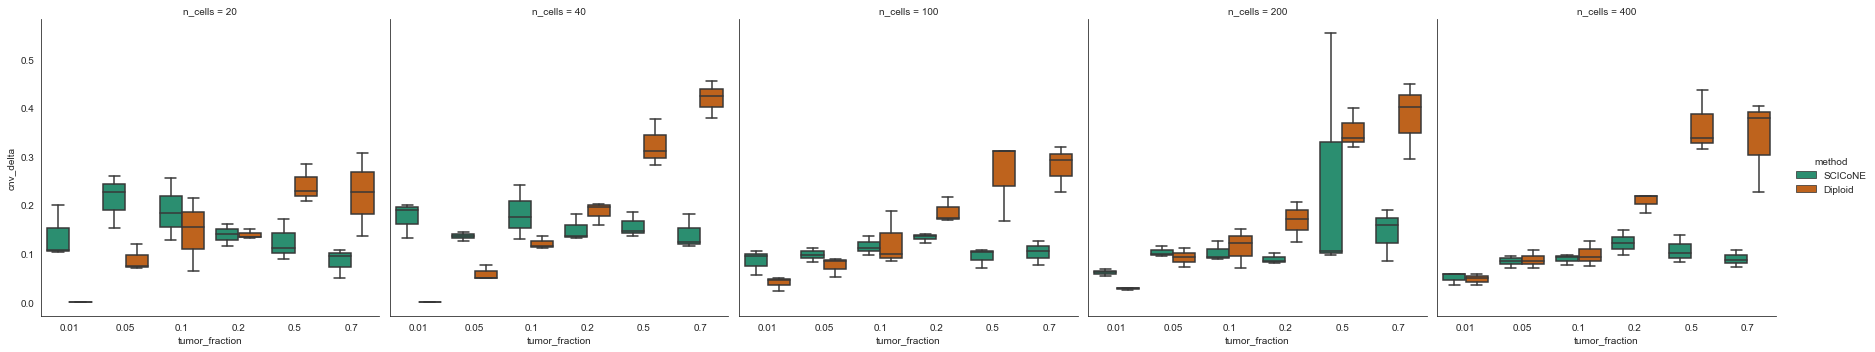

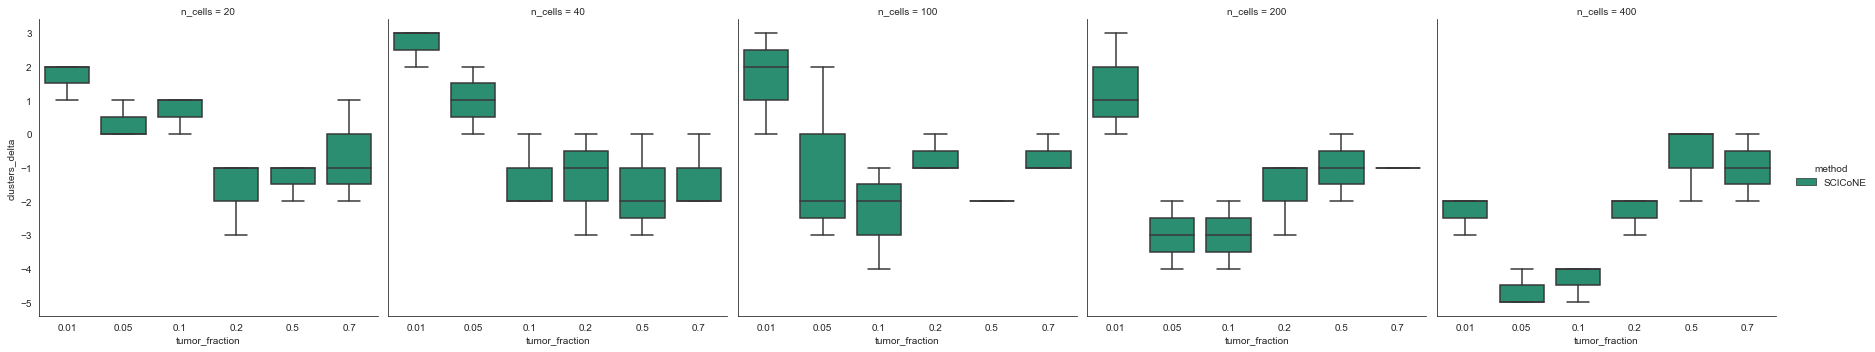

In [ ]:
import seaborn as sns
ax = sns.catplot(x="tumor_fraction", y="cnv_delta", hue="method", col="n_cells",
                 data=cnvs_deltas, palette="Dark2", kind='box')
plt.show()

ax = sns.catplot(x="tumor_fraction", y="clusters_delta", hue="method", col="n_cells",
                 data=num_clusters, palette="Dark2", kind='box')
plt.show()